# Vorbereitungen
## Libraries & Funktionen
### Import der nötigen Libraries

In [1]:
import yfinance as yf
import backtrader as bt
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

### Abruf und Vorbereitung der ETF-Daten


In [2]:
### ETF-Daten abrufen und vorbereiten
def fetch_etf_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError(f"Keine Daten für {ticker} im angegebenen Zeitraum gefunden.")
    # Backtrader benötigt spezifische Spaltennamen
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    data.columns = ['open', 'high', 'low', 'close', 'volume']
    data['openinterest'] = 0  # Backtrader benötigt diese Spalte
    return data

### Ausführung Backtesting


In [3]:
def run_backtest(data, strategy, seed_capital, commission):
    # Daten für Backtrader vorbereiten
    data_feed = bt.feeds.PandasData(dataname=data)

    # Cerebro (Backtest-Engine) initialisieren
    cerebro = bt.Cerebro()
    cerebro.adddata(data_feed)
    cerebro.addstrategy(strategy)

    # Startkapital festlegen
    cerebro.broker.setcash(seed_capital)
    cerebro.broker.setcommission(commission)  # 0.1% Handelsgebühr

    print("Startkapital: {:.2f}".format(cerebro.broker.getvalue()))

    # Backtest ausführen
    cerebro.run()

    print("Endkapital: {:.2f}".format(cerebro.broker.getvalue()))

    # Ergebnisse plotten
    #cerebro.plot(style='candlestick')

    return cerebro.broker.getvalue()



In [4]:
def backtest_and_collect(data, strategies, seed_capital, commission):
    earnings = []
    for strategy, strategy_name in strategies:
        data_feed = bt.feeds.PandasData(dataname=data)
        cerebro = bt.Cerebro()
        cerebro.adddata(data_feed)
        cerebro.addstrategy(strategy)
        cerebro.broker.setcash(seed_capital)
        cerebro.broker.setcommission(commission)
        strategies_run = cerebro.run()
        final_value = cerebro.broker.getvalue()

        # Signale sammeln
        strat_instance = strategies_run[0]
        buy_signals = getattr(strat_instance, "buy_signals", 0)
        sell_signals = getattr(strat_instance, "sell_signals", 0)

        earnings.append({
            "Strategy": strategy_name,
            "Earnings": final_value,
            "Seed Capital": seed_capital,
            "Profit": final_value - seed_capital,
            "Profit_Percent": (final_value / seed_capital * 100) - 100,
            "Buy Signals": buy_signals,
            "Sell Signals": sell_signals,
            "Cerebro": cerebro,
        })
    return earnings

### Tabelle mit Matplotlib darstellen

In [5]:
def display_table_with_matplotlib(df):
    fig, ax = plt.subplots(figsize=(10, len(df) * 0.5))  # Dynamische Höhe basierend auf Zeilenanzahl
    ax.axis('tight')
    ax.axis('off')

    # Tabelle hinzufügen
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

    # Stil anpassen
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))

    # Optional: Farben anpassen
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header-Zeilen
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4CAF50')  # Grüner Header
        elif key[0] % 2 == 0:  # Alternierende Zeilen
            cell.set_facecolor('#f9f9f9')  # Hellgrau
        else:
            cell.set_facecolor('#ffffff')  # Weiß

    plt.show()

## Definition der einzelnen Strategien
### Standard Moving Average

In [6]:
class SmaStrategy(bt.Strategy):
    params = (("short_sma", 10), ("long_sma", 50))

    def __init__(self):
        self.short_sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.short_sma)
        self.long_sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.long_sma)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.short_sma > self.long_sma and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.short_sma < self.long_sma and self.position:
            self.sell()
            self.sell_signals += 1

### Linear Weighted Moving Average

In [7]:
class LwmaStrategy(bt.Strategy):
    params = (("short_lwma", 10), ("long_lwma", 50))

    def __init__(self):
        self.short_lwma = bt.indicators.WeightedMovingAverage(self.data.close, period=self.params.short_lwma)
        self.long_lwma = bt.indicators.WeightedMovingAverage(self.data.close, period=self.params.long_lwma)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.short_lwma > self.long_lwma and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.short_lwma < self.long_lwma and self.position:
            self.sell()
            self.sell_signals += 1

### Exponential Weighted Moving Average

In [8]:
class EwmaStrategy(bt.Strategy):
    params = (("short_ewma", 10), ("long_ewma", 50))

    def __init__(self):
        self.short_ewma = bt.indicators.ExponentialMovingAverage(self.data.close, period=self.params.short_ewma)
        self.long_ewma = bt.indicators.ExponentialMovingAverage(self.data.close, period=self.params.long_ewma)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.short_ewma > self.long_ewma and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.short_ewma < self.long_ewma and self.position:
            self.sell()
            self.sell_signals += 1

### Moving Average Crossover Divergence

In [9]:
class MacdStrategy(bt.Strategy):
    params = (("fast_period", 12), ("slow_period", 26), ("signal_period", 9))

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close, period_me1=self.params.fast_period, period_me2=self.params.slow_period, period_signal=self.params.signal_period)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.macd.macd > self.macd.signal and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.macd.macd < self.macd.signal and self.position:
            self.sell()
            self.sell_signals += 1

### Relative Strength Index (RSI)

In [10]:
class RsiStrategy(bt.Strategy):
    params = (("period", 14), ("overbought", 70), ("oversold", 30))

    def __init__(self):
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.period)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.rsi < self.params.oversold and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.rsi > self.params.overbought and self.position:
            self.sell()
            self.sell_signals += 1

### Bollinger Bands

In [11]:
class BollingerBandsStrategy(bt.Strategy):
    params = (("period", 20), ("devfactor", 2.0))

    def __init__(self):
        self.bb = bt.indicators.BollingerBands(self.data.close, period=self.params.period, devfactor=self.params.devfactor)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.data.close < self.bb.bot and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.data.close > self.bb.top and self.position:
            self.sell()
            self.sell_signals += 1

### Momentum


In [12]:
class MomentumStrategy(bt.Strategy):
    params = (("period", 12),)

    def __init__(self):
        self.momentum = bt.indicators.Momentum(self.data.close, period=self.params.period)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.momentum > 1.0 and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.momentum < 1.0 and self.position:
            self.sell()
            self.sell_signals += 1

### Price Rate-of-Change (ROC)


In [13]:
class RoCStrategy(bt.Strategy):
    params = (("period", 12),)

    def __init__(self):
        self.roc = bt.indicators.RateOfChange(self.data.close, period=self.params.period)
        self.buy_signals = 0
        self.sell_signals = 0

    def next(self):
        if self.roc > 0 and not self.position:
            self.buy()
            self.buy_signals += 1
        elif self.roc < 0 and self.position:
            self.sell()
            self.sell_signals += 1

# Durchführung der Tests
## Definition der Parameter

In [14]:
# Parameter
etfs = {
    "SMI ETF": "SMI",
    "DAX ETF": "EXS1.DE",
}
start_date = "2015-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")
seed_capital = 100000
commission = 0.001

# Strategien definieren
strategies = [
    (SmaStrategy, "SMA"),
    (LwmaStrategy, "LWMA"),
    (EwmaStrategy, "EWMA"),
    (MacdStrategy, "MACD"),
    (RsiStrategy, "RSI"),
    (BollingerBandsStrategy, "Bollinger Bands"),
    (MomentumStrategy, "Momentum"),
    (RoCStrategy, "Rate of Change"),
]

In [15]:
# Ergebnisse anzeigen
earnings = []
for name, ticker in etfs.items():
    data = fetch_etf_data(ticker, start_date, end_date)
    data.index = data.index.tz_localize(None)
    etf_earnings = backtest_and_collect(data, strategies, seed_capital, commission)
    for result in etf_earnings:
        result["ETF"] = name
    earnings.extend(etf_earnings)

# DataFrame erstellen
earnings_df = pd.DataFrame(earnings)

# Spalten sortieren
earnings_df = earnings_df[["ETF", "Strategy", "Earnings", "Seed Capital", "Profit", "Profit_Percent", "Buy Signals", "Sell Signals", "Cerebro"]]

# Zahlen runden
earnings_df[["Earnings", "Profit", "Profit_Percent"]] = earnings_df[["Earnings", "Profit", "Profit_Percent"]].round(2)

# Nach Strategie sortieren
earnings_df = earnings_df.sort_values(by=["Strategy", "ETF"]).reset_index(drop=True)

# DataFrame anzeigen
print(earnings_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


        ETF         Strategy   Earnings  Seed Capital  Profit  Profit_Percent  \
0   DAX ETF  Bollinger Bands  100050.67        100000   50.67            0.05   
1   SMI ETF  Bollinger Bands   99994.43        100000   -5.57           -0.01   
2   DAX ETF             EWMA  100025.47        100000   25.47            0.03   
3   SMI ETF             EWMA   99999.71        100000   -0.29           -0.00   
4   DAX ETF             LWMA  100009.52        100000    9.52            0.01   
5   SMI ETF             LWMA  100000.04        100000    0.04            0.00   
6   DAX ETF             MACD   99970.25        100000  -29.75           -0.03   
7   SMI ETF             MACD  100001.35        100000    1.35            0.00   
8   DAX ETF         Momentum   99967.26        100000  -32.74           -0.03   
9   SMI ETF         Momentum  100000.90        100000    0.90            0.00   
10  DAX ETF              RSI  100041.55        100000   41.55            0.04   
11  SMI ETF              RSI

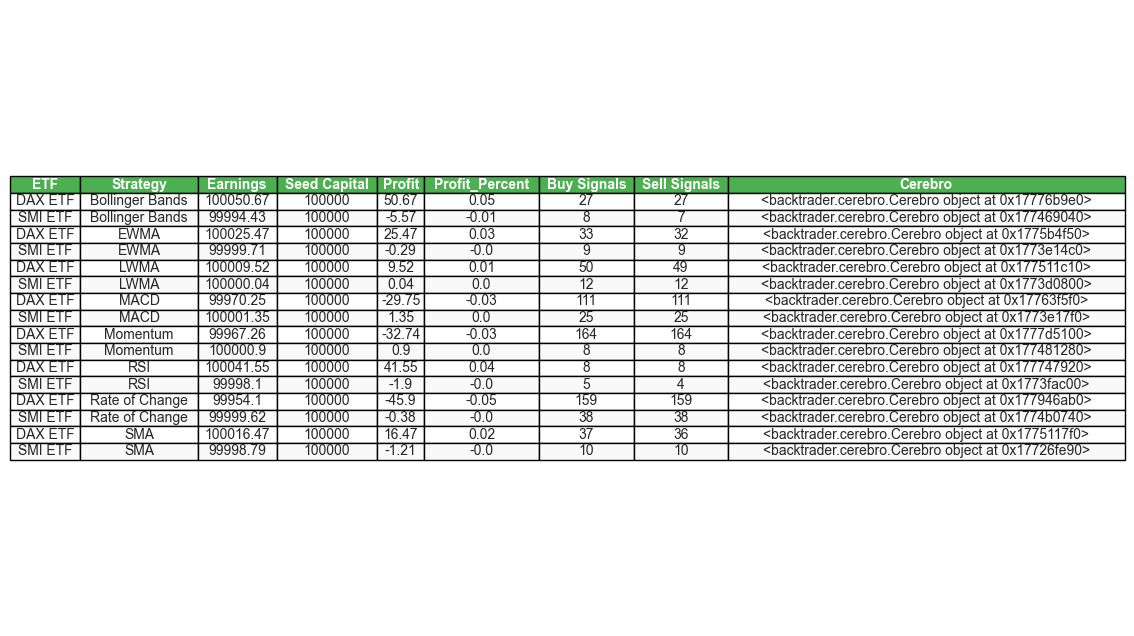

In [16]:
# Tabelle darstellen
display_table_with_matplotlib(earnings_df)

In [18]:
# Anzahl der Subplots bestimmen
num_plots = len(earnings_df)
cols = 3  # Anzahl der Spalten im Raster
rows = (num_plots + cols - 1) // cols  # Anzahl der Zeilen

# Plots erstellen
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

for idx, (ax, row) in enumerate(zip(axes, earnings_df.itertuples(index=False))):
    # Titel setzen
    title = f"{row.ETF} - {row.Strategy}"

    # Plotten
    row.Cerebro.plot(ax=ax, style='candlestick')

    # Titel hinzufügen
    ax.set_title(title, fontsize=10)

# Leere Subplots ausblenden
for idx in range(num_plots, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/var/folders/dn/9hfxsn_x62z_y8g2kq231zc80000gn/T/ipykernel_74855/2973040423.py:24: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()
